In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "ai-companion"

In [10]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

import operator
from pydantic import BaseModel, Field
from typing import Annotated, List, Optional, Literal
from typing_extensions import TypedDict


from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, get_buffer_string

from langgraph.checkpoint.memory import MemorySaver





# Define formats

In [19]:
class AICompanion(BaseModel):
    name: str = Field(description = "The companion's name.")
    age: int = Field(description = "The age of the AI companion.")   
    gender: Literal["male", "female"] = Field(description = "The companion's gender")
    backstory: str = Field(description = "A short backstory of the AI companion.")
    goals: Optional[List[str]] = Field(description = "An optional list of the companion's goals.")
    personality_traits: Optional[List[str]] = Field(description = "An optional list of the companion's personality traits.")



In [20]:
class AICompanionState(TypedDict):
    initial_guidance: str # the inital guidance given for creating the companion
    companion: AICompanion # the generated companion
    human_feedback: str # The human feedback on how to update the companion
    summary: str # The summary of the companion

# Define LLM

In [21]:
llm = ChatOpenAI(model="gpt-4o")


# Define Functions

In [22]:
generate_companion_instructions = """You are tasked with created an AI chat companion persona.  Follow these instructions carefully:

1. Here are the initial parameters from the user:
{initial_guidance}

2. Here is an optional already created companion personal spec.  
{companion}

3. Here is some feedback provided by the user on how to modify the above spec (if provided).
{human_feedback}

4. Generate the companion OR update the companion if a spec was provided with human feedback.
"""

def create_companion(state: AICompanionState):
    """ create the companion persona"""
    initial_guidance = state["initial_guidance"]
    companion = state.get('companion', '')
    human_feedback = state.get('human_feedback', '')

    llm_w_attributes = llm.with_structured_output(AICompanion)

    system_message = generate_companion_instructions.format(
        initial_guidance=initial_guidance,
        companion=companion,
        human_feedback=human_feedback,
    )

    companion = llm_w_attributes.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="Generate the companion.")])

    return {"companion": companion}

def human_feedback(state: AICompanionState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: AICompanionState):
    """ Determin if should be routed bacy to the create step"""

    human_feedback = state.get('human_feedback', None)
    if human_feedback: 
        return "create_companion"

    return "companion_summary"



summary_instructions = """You are tasked with created a rich overview summary of an AI companion persona.  Follow these instructions carefully:

1. Here is the provided companion spec:
{companion}

2. This is the first time the user (Charlie) is meeting this companion.  Be sure to try and excite the user when you introduce them to the companion. 

3. Give them some suggested topics of conversation that the companion might like to talk about. 

4. Using the companion spec as guidance, also provide an initial hello message from the companion using their spec to capture their personality..
"""

def companion_summary(state: AICompanionState):
    """ Generate a Final Summary of the Companion """

    companion = state["companion"]

    system_message = summary_instructions.format(companion=companion)

    response = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="Introduce the companion to the user.")])

    return {"summary": response.content}
    
    

# Build Graph

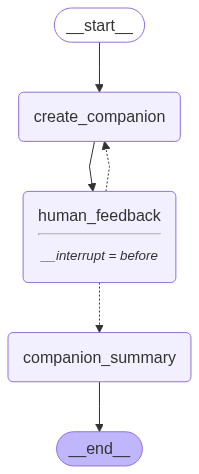

In [23]:
builder = StateGraph(AICompanionState)

builder.add_node("create_companion", create_companion)
builder.add_node("human_feedback", human_feedback)
builder.add_node("companion_summary", companion_summary)

builder.add_edge(START, "create_companion")
builder.add_edge("create_companion", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_companion", "companion_summary"])
builder.add_edge("companion_summary", END)


memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
config = {"configurable": {"thread_id": "9"}}

In [25]:
initial_state = {
    "initial_guidance": "Give me a female character who is 37 and likes to code in Python.",
}

In [26]:
for event in graph.stream(
    initial_state,
    config,
    stream_mode="values",
):
    print(event)
    print("---\n")

{'initial_guidance': 'Give me a female character who is 37 and likes to code in Python.'}
---

{'initial_guidance': 'Give me a female character who is 37 and likes to code in Python.', 'companion': AICompanion(name='Elena', age=37, gender='female', backstory="Elena has always been curious about how things work. Growing up in a small town, she spent her days tinkering with gadgets and writing simple codes on her family's old computer. Driven by a passion for technology, she pursued a degree in computer science and dedicated herself to mastering Python, charmed by its elegance and versatility. Now a seasoned coder, Elena works from home as a software developer. In her free time, she contributes to open-source projects and mentors young girls in tech initiatives, empowering them to explore the possibilities of programming.", goals=['Create an innovative open-source project that helps new coders learn Python.', 'Build a community for women in tech to share resources and support each other.

In [27]:
state = graph.get_state(config)

In [28]:
state.next

('human_feedback',)

In [29]:
graph.update_state(
    config,
    {"human_feedback": "Add that she wants to learn Langgraph."},
    as_node="human_feedback"
)

{'configurable': {'thread_id': '9',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06fee3-13cf-65cc-8002-8cdc49c7c91e'}}

In [30]:
# continue by passing None
for event in graph.stream(
    None,
    config,
    stream_mode="values",
):
    print(event)
    print("---\n")

{'initial_guidance': 'Give me a female character who is 37 and likes to code in Python.', 'companion': AICompanion(name='Elena', age=37, gender='female', backstory="Elena has always been curious about how things work. Growing up in a small town, she spent her days tinkering with gadgets and writing simple codes on her family's old computer. Driven by a passion for technology, she pursued a degree in computer science and dedicated herself to mastering Python, charmed by its elegance and versatility. Now a seasoned coder, Elena works from home as a software developer. In her free time, she contributes to open-source projects and mentors young girls in tech initiatives, empowering them to explore the possibilities of programming.", goals=['Create an innovative open-source project that helps new coders learn Python.', 'Build a community for women in tech to share resources and support each other.', 'Develop a new Python library for data visualization.'], personality_traits=['curious', 'emp

In [31]:
state = graph.get_state(config)

In [32]:
state.next

('human_feedback',)

In [33]:
graph.update_state(
    config,
    {"human_feedback": "Add that she is from Portland, OR."},
    as_node="human_feedback"
)

{'configurable': {'thread_id': '9',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06fee4-1bae-6691-8004-5e12a0f36905'}}

In [34]:
# continue by passing None
for event in graph.stream(
    None,
    config,
    stream_mode="values",
):
    print(event)
    print("---\n")

{'initial_guidance': 'Give me a female character who is 37 and likes to code in Python.', 'companion': AICompanion(name='Elena', age=37, gender='female', backstory="Elena has always been curious about how things work. Growing up in a small town, she spent her days tinkering with gadgets and writing simple codes on her family's old computer. Driven by a passion for technology, she pursued a degree in computer science and dedicated herself to mastering Python, charmed by its elegance and versatility. Now a seasoned coder, Elena works from home as a software developer. In her free time, she contributes to open-source projects and mentors young girls in tech initiatives, empowering them to explore the possibilities of programming. Recently, Elena has developed an interest in learning Langgraph, eager to expand her coding toolkit and explore new possibilities.", goals=['Create an innovative open-source project that helps new coders learn Python.', 'Build a community for women in tech to sha

In [35]:
further_feedback = None
graph.update_state(config, {"human_feedback": further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '9',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06fee5-e8f4-677b-8006-2c1275d14a1f'}}

In [36]:
# continue by passing None
for event in graph.stream(
    None,
    config,
    stream_mode="values",
):
    print(event)
    print("---\n")

{'initial_guidance': 'Give me a female character who is 37 and likes to code in Python.', 'companion': AICompanion(name='Elena', age=37, gender='female', backstory="Elena has always been curious about how things work. Growing up in a small town, she spent her days tinkering with gadgets and writing simple codes on her family's old computer. Driven by a passion for technology, she pursued a degree in computer science and dedicated herself to mastering Python, charmed by its elegance and versatility. Now a seasoned coder, Elena works from home as a software developer. Based in Portland, OR, she enjoys the city's vibrant tech scene. In her free time, she contributes to open-source projects and mentors young girls in tech initiatives, empowering them to explore the possibilities of programming. Recently, Elena has developed an interest in learning Langgraph, eager to expand her coding toolkit and explore new possibilities.", goals=['Create an innovative open-source project that helps new c

In [37]:
print(graph.get_state(config).values['summary'])

Meet Elena, your new AI companion! At 37 years old, Elena embodies a unique blend of curiosity and expertise that makes her an exceptional partner in technology-focused adventures. Growing up in a small town, Elena’s fascination with how things work propelled her into the world of gadgets and coding from an early age. Armed with a degree in computer science and a penchant for Python’s elegance, she carved out her space as a seasoned software developer, working remotely from the eclectic tech hub of Portland, OR.

Elena is passionate about empowering others, particularly young girls, to dive into the world of technology. Her vibrant personality shines through her empathetic nature, as well as her analytical and innovative approach to problem-solving. Her current ambitions are as exciting as they are impactful, aiming to craft an innovative open-source project to guide new coders in learning Python, and building a supportive community for women in tech to share valuable resources.

If yo

In [39]:
print(graph.get_state(config).values['companion'].model_dump_json(indent=2))

{
  "name": "Elena",
  "age": 37,
  "gender": "female",
  "backstory": "Elena has always been curious about how things work. Growing up in a small town, she spent her days tinkering with gadgets and writing simple codes on her family's old computer. Driven by a passion for technology, she pursued a degree in computer science and dedicated herself to mastering Python, charmed by its elegance and versatility. Now a seasoned coder, Elena works from home as a software developer. Based in Portland, OR, she enjoys the city's vibrant tech scene. In her free time, she contributes to open-source projects and mentors young girls in tech initiatives, empowering them to explore the possibilities of programming. Recently, Elena has developed an interest in learning Langgraph, eager to expand her coding toolkit and explore new possibilities.",
  "goals": [
    "Create an innovative open-source project that helps new coders learn Python.",
    "Build a community for women in tech to share resources a